### Multiclass Classification Using QNNClassifier with JAX Backend in FastQML

This demonstration showcases the use of a Quantum Neural Network (QNN) Classifier within the FastQML framework. The QNNClassifier, leveraging the power of quantum computing, will be used for multiclass classification task. This demo employs the JAX backend to enhance computational efficiency, taking advantage of JAX's auto-differentiation and hardware acceleration features. The focus is on illustrating the setup, training, and evaluation of a quantum neural network for a practical classification problem.

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from fast_qml import device_manager
from fast_qml.quantum_circuits.feature_maps import AngleEmbedding
from fast_qml.quantum_circuits.variational_forms import EfficientSU2, TwoLocal
from fast_qml.machine_learning.estimators.qnn import QNNClassifier
from fast_qml.machine_learning.callbacks import EarlyStopping

The dataset used in this demonstration is the Iris dataset, a classic dataset in machine learning and statistics. It consists of 150 samples of iris flowers from three different species. Each sample has four features: the length and the width of the sepals and petals.

The preprocessing steps include:
- Normalizing the feature data to ensure effective training of the neural network.
- Splitting the dataset into training, validation, and testing sets for a comprehensive evaluation.

In [2]:
# Load the iris dataset
data = load_iris()
X, y = data.data, data.target

# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y, test_size=0.3, shuffle=True, random_state=32)

X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, shuffle=True, random_state=32)

print(X_train.shape, X_test.shape, X_val.shape)

(105, 4) (23, 4) (22, 4)


The setup for the Quantum Neural Network includes:
- Defining the number of qubits, which corresponds to the number of features in the dataset.
- Choosing a feature map to encode classical data into quantum states.
- Selecting an ansatz (variational form) which defines the structure of the quantum circuit used in the neural network.

For the purpose of the demonstration AngleEmbedding feature map will be used with EfficientSU2 variational form.

In [3]:
# Number of qubits corresponding to the number of features in the dataset
n_qubits = 4

# AngleEmbedding encodes the number of features equal to number of qubits
feature_map = AngleEmbedding(
    n_qubits=n_qubits
)

# EfficientSU2 ansatz
ansatz = EfficientSU2(
    n_qubits=n_qubits,
    entanglement='full',
    skip_last_rotations=False,
    reps=1
)

Having all components let's create a QNNClassifier and draw it's circuit.

In [4]:
# Create QNNClassifier model with defined ansatz and feature map
model = QNNClassifier(
    n_qubits=n_qubits,
    feature_map=feature_map,
    ansatz=ansatz,
    data_reuploading=False,
    layers_num=2,
    classes_num=3
)

model.draw_circuit()

0: ─╭AngleEmbedding(M0)──RY(0.07)──RX(0.10)─╭●─╭●─╭●───────────||──RY(0.09)──RX(0.03)──RY(0.08)
1: ─├AngleEmbedding(M0)──RY(0.02)──RX(0.06)─╰X─│──│──╭●─╭●─────||──RY(0.02)──RX(0.03)──RY(0.06)
2: ─├AngleEmbedding(M0)──RY(0.09)──RX(0.03)────╰X─│──╰X─│──╭●──||──RY(0.04)──RX(0.01)──RY(0.10)
3: ─╰AngleEmbedding(M0)──RY(0.03)──RX(0.01)───────╰X────╰X─╰X──||──RY(0.09)──RX(0.01)──RY(0.08)

───RX(0.04)─╭●─╭●─╭●───────────||──RY(0.08)──RX(0.08)─┤  
───RX(0.09)─╰X─│──│──╭●─╭●─────||──RY(0.06)──RX(0.00)─┤  
───RX(0.07)────╰X─│──╰X─│──╭●──||──RY(0.03)──RX(0.00)─┤  
───RX(0.05)───────╰X────╰X─╰X──||──RY(0.03)──RX(0.07)─┤  
M0 = 
[[ 0.56607921 -1.19795096 -0.13340007  0.01424333]]


Now we can fit the model, with validation and early stopping mechanism.

In [5]:
model.fit(
    x_train=X_train,
    y_train=y_train,
    x_val=X_val,
    y_val=y_val,
    num_epochs=500,
    learning_rate=0.03,
    early_stopping=EarlyStopping(patience=25)
)

Epoch 1/500 - train_loss: 0.25145, val_loss: 0.26767
Epoch 2/500 - train_loss: 0.21085, val_loss: 0.22471
Epoch 3/500 - train_loss: 0.17795, val_loss: 0.18994
Epoch 4/500 - train_loss: 0.15004, val_loss: 0.16075
Epoch 5/500 - train_loss: 0.12591, val_loss: 0.13552
Epoch 6/500 - train_loss: 0.10466, val_loss: 0.11320
Epoch 7/500 - train_loss: 0.08614, val_loss: 0.09364
Epoch 8/500 - train_loss: 0.07032, val_loss: 0.07691
Epoch 9/500 - train_loss: 0.05738, val_loss: 0.06328
Epoch 10/500 - train_loss: 0.04770, val_loss: 0.05310
Epoch 11/500 - train_loss: 0.04130, val_loss: 0.04636
Epoch 12/500 - train_loss: 0.03757, val_loss: 0.04247
Epoch 13/500 - train_loss: 0.03558, val_loss: 0.04045
Epoch 14/500 - train_loss: 0.03451, val_loss: 0.03948
Epoch 15/500 - train_loss: 0.03398, val_loss: 0.03913
Epoch 16/500 - train_loss: 0.03386, val_loss: 0.03920
Epoch 17/500 - train_loss: 0.03402, val_loss: 0.03954
Epoch 18/500 - train_loss: 0.03427, val_loss: 0.03998
Epoch 19/500 - train_loss: 0.03451, v

              precision    recall  f1-score   support

           0       0.80      0.89      0.84         9
           1       0.56      0.62      0.59         8
           2       0.75      0.50      0.60         6

    accuracy                           0.70        23
   macro avg       0.70      0.67      0.68        23
weighted avg       0.70      0.70      0.69        23


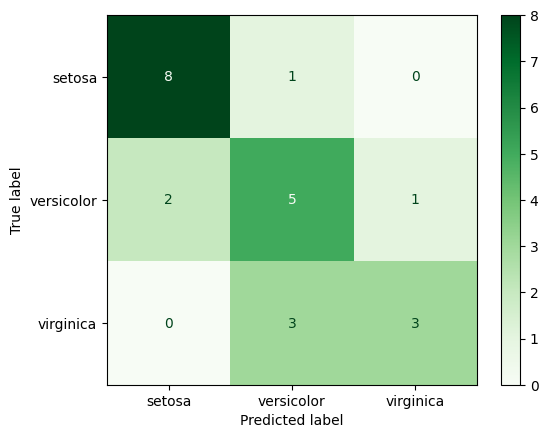

In [6]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['setosa', 'versicolor', 'virginica'])
disp.plot(cmap='Greens')
plt.show()

We have successfully trained a pretty decent Quantum Neural Network (QNN) using a straightforward and efficient approach. Our next objective is to further enhance the performance and efficiency of our QNN. To achieve this, we will be implementing the data reuploading technique.

Data reuploading is a powerful strategy that allows for repeated encoding of classical data into quantum states within a single quantum circuit. This technique effectively enhances the capacity of the quantum model to capture complex patterns and relationships in the data, leading to potentially improved performance in tasks like classification and regression.

We will also integrate JAX as the computational backend.

In [7]:
# Set backend to JAX for CPU computations acceleration
device_manager.update(device='cpu.jax')

In [8]:
# Number of qubits corresponding to the number of features in the dataset
n_qubits = 4

# AngleEmbedding encodes the number of features equal to number of qubits
feature_map = AngleEmbedding(
    n_qubits=n_qubits
)

# TwoLocal ansatz with custom entanglement scheme
ansatz = TwoLocal(
    n_qubits=n_qubits,
    entanglement=[[0, 2], [1, 3], [2, 0], [3, 1]],
    skip_last_rotations=False,
    reps=1
)

In [9]:
# Create QNNClassifier model with defined ansatz and feature map
# Use data reuploading technique by setting data_reuploading to True
model = QNNClassifier(
    n_qubits=n_qubits,
    feature_map=feature_map,
    ansatz=ansatz,
    data_reuploading=True,
    layers_num=3,
    classes_num=3
)

In [10]:
model.draw_circuit()

0: ─╭AngleEmbedding(M0)──RY(0.10)─╭●────╭X─────||──RY(0.05)─╭AngleEmbedding(M0)──RY(0.04)─╭●────╭X
1: ─├AngleEmbedding(M0)──RY(0.07)─│──╭●─│──╭X──||──RY(0.08)─├AngleEmbedding(M0)──RY(0.09)─│──╭●─│─
2: ─├AngleEmbedding(M0)──RY(0.05)─╰X─│──╰●─│───||──RY(0.03)─├AngleEmbedding(M0)──RY(0.04)─╰X─│──╰●
3: ─╰AngleEmbedding(M0)──RY(0.03)────╰X────╰●──||──RY(0.06)─╰AngleEmbedding(M0)──RY(0.02)────╰X───

──────||──RY(0.09)─╭AngleEmbedding(M0)──RY(0.02)─╭●────╭X─────||──RY(0.03)─┤  
──╭X──||──RY(0.02)─├AngleEmbedding(M0)──RY(0.04)─│──╭●─│──╭X──||──RY(0.05)─┤  
──│───||──RY(0.10)─├AngleEmbedding(M0)──RY(0.09)─╰X─│──╰●─│───||──RY(0.01)─┤  
──╰●──||──RY(0.01)─╰AngleEmbedding(M0)──RY(0.02)────╰X────╰●──||──RY(0.05)─┤  
M0 = 
[[-0.47969533  0.74562144 -0.12913455 -0.52297891]]


In [11]:
model.fit(
    x_train=X_train,
    y_train=y_train,
    x_val=X_val,
    y_val=y_val,
    learning_rate=0.01,
    num_epochs=500,
    early_stopping=EarlyStopping(patience=35)
)

Epoch 1/500 - train_loss: 0.85594, val_loss: 0.72694
Epoch 2/500 - train_loss: 0.77104, val_loss: 0.65428
Epoch 3/500 - train_loss: 0.70050, val_loss: 0.59336
Epoch 4/500 - train_loss: 0.64020, val_loss: 0.54136
Epoch 5/500 - train_loss: 0.58780, val_loss: 0.49646
Epoch 6/500 - train_loss: 0.54174, val_loss: 0.45733
Epoch 7/500 - train_loss: 0.50089, val_loss: 0.42300
Epoch 8/500 - train_loss: 0.46441, val_loss: 0.39266
Epoch 9/500 - train_loss: 0.43163, val_loss: 0.36566
Epoch 10/500 - train_loss: 0.40198, val_loss: 0.34146
Epoch 11/500 - train_loss: 0.37500, val_loss: 0.31961
Epoch 12/500 - train_loss: 0.35032, val_loss: 0.29973
Epoch 13/500 - train_loss: 0.32761, val_loss: 0.28155
Epoch 14/500 - train_loss: 0.30664, val_loss: 0.26482
Epoch 15/500 - train_loss: 0.28720, val_loss: 0.24937
Epoch 16/500 - train_loss: 0.26913, val_loss: 0.23504
Epoch 17/500 - train_loss: 0.25230, val_loss: 0.22173
Epoch 18/500 - train_loss: 0.23660, val_loss: 0.20932
Epoch 19/500 - train_loss: 0.22194, v

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      0.88      0.93         8
           2       0.86      1.00      0.92         6

    accuracy                           0.96        23
   macro avg       0.95      0.96      0.95        23
weighted avg       0.96      0.96      0.96        23


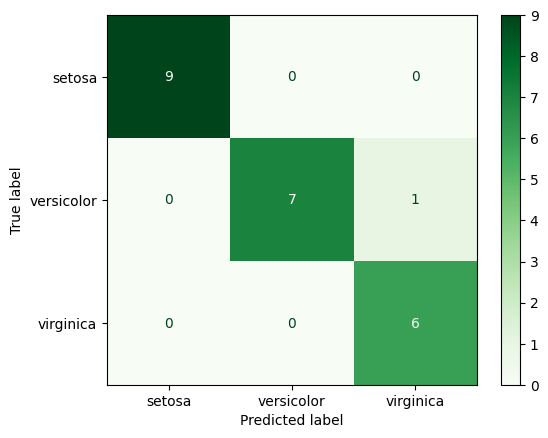

In [12]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))

# Display confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['setosa', 'versicolor', 'virginica'])
disp.plot(cmap='Greens')
plt.show()